In [2]:
!pip install gast stable-baselines3 py-cpuinfo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 37.3 MB/s eta 0:00:00


In [3]:
pip install astor


In [16]:
import gast
import time
import astor  # Use this to convert AST back to Python code

class PythonCodeOptimizer:
    def __init__(self, code):
        self.code = code
        self.optimized_code = code

    def unroll_loops(self, node):
        """
        Unroll loops by duplicating the loop body for a fixed number of iterations.
        """
        if isinstance(node, gast.For):
            if (
                isinstance(node.iter, gast.Call)
                and hasattr(node.iter.func, "id")
                and node.iter.func.id == "range"
            ):
                try:
                    start = node.iter.args[0].value if len(node.iter.args) > 0 else 0
                    stop = node.iter.args[1].value if len(node.iter.args) > 1 else 10
                    unrolled_body = []
                    for i in range(start, stop):
                        for stmt in node.body:
                            # Copy the statement and adjust locations
                            stmt_copy = gast.copy.deepcopy(stmt)
                            stmt_copy = gast.fix_missing_locations(stmt_copy)
                            unrolled_body.append(stmt_copy)
                    return unrolled_body
                except Exception as e:
                    print("Error during loop unrolling:", e)
        return node

    def eliminate_dead_code(self, node):
        """
        Eliminate dead code such as unreachable branches or unused functions.
        """
        if isinstance(node, gast.If) and isinstance(node.test, gast.Constant) and not node.test.value:
            return []  # Remove this branch
        if isinstance(node, gast.FunctionDef):
            new_body = []
            for stmt in node.body:
                new_body.append(stmt)
                if isinstance(stmt, gast.Return):
                    break  # Remove everything after the return statement
            node.body = new_body
        return node

    def optimize(self):
        """
        Parse the code, apply optimizations, and store the optimized code as a string.
        """
        try:
            tree = gast.parse(self.code)
            tree = gast.NodeTransformer().visit(tree)
            # Convert the optimized AST back to Python code
            self.optimized_code = astor.to_source(gast.gast_to_ast(tree))
        except Exception as e:
            print("Error during optimization:", e)

    def measure_execution_time(self, code):
        """
        Measure execution time of the given code.
        """
        start = time.time()
        try:
            exec(code, {})
        except Exception as e:
            print("Execution error:", e)
        return time.time() - start

    def compare(self):
        """
        Compare execution times of original and optimized code.
        """
        print(self.optimized_code)
        print("Original Code Execution Time:")
        original_time = self.measure_execution_time(self.code)

        print("Optimized Code Execution Time:")
        optimized_time = self.measure_execution_time(self.optimized_code)

        return original_time, optimized_time




In [5]:
!pip install shimmy


In [6]:
!pip install shimmy stable-baselines3 gymnasium


In [7]:
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

class CodeOptimizationEnv(gym.Env):
    def __init__(self, optimizer):
        super(CodeOptimizationEnv, self).__init__()
        self.optimizer = optimizer
        self.actions = ['none', 'loop_unrolling', 'dead_code_elimination']
        self.action_space = spaces.Discrete(len(self.actions))  # Discrete action space
        self.observation_space = spaces.Box(low=0, high=255, shape=(len(optimizer.code),), dtype=int)  # Simplistic observation space
        self.current_code = optimizer.code
        self.optimized_code = optimizer.code
        self.original_exec_time = optimizer.measure_execution_time(optimizer.code)
        self.current_exec_time = self.original_exec_time

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        self.current_code = self.optimizer.code
        self.optimized_code = self.optimizer.code
        self.current_exec_time = self.original_exec_time
        return self._get_observation(), {}

    def step(self, action_index):
        """
        Perform an action and return the next state, reward, done, truncated, and info.
        """
        action = self.actions[action_index]
        reward = 0
        done = False
        truncated = False

        # Apply the chosen optimization
        if action == 'loop_unrolling':
            self.optimized_code = self.optimizer.unroll_loops(self.current_code)
        elif action == 'dead_code_elimination':
            self.optimized_code = self.optimizer.eliminate_dead_code(self.current_code)
        else:
            self.optimized_code = self.current_code

        # Measure new execution time
        new_exec_time = self.optimizer.measure_execution_time(self.optimized_code)

        # Calculate reward as time reduction
        reward = self.current_exec_time - new_exec_time
        self.current_exec_time = new_exec_time

        # Check if optimization is sufficient
        if new_exec_time <= 0.1 * self.original_exec_time:
            done = True  # Stop if the code is optimized enough

        return self._get_observation(), reward, done, truncated, {}

    def _get_observation(self):
        """
        Simplified observation: code length represented as a 1D array.
        """
        return [ord(c) for c in self.current_code]  # Convert characters to ASCII values

    def render(self, mode='human'):
        """
        Render the current state (print the optimized code).
        """
        print("\nOptimized Code:")
        print(self.optimized_code)

# Define the optimizer and RL environment
def make_env():
    return CodeOptimizationEnv(optimizer)

# Example unoptimized code
unoptimized_code = """
for i in range(10):
    print(i)
# Unreachable code
if False:
    print("This will never run")

def example():
    return 42
    print("Dead code")
"""

# Initialize the optimizer and environment
optimizer = PythonCodeOptimizer(unoptimized_code)
env = DummyVecEnv([make_env])

# Train PPO agent
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=5000)
model.save("rl_code_optimizer")

Streaming output truncated to the last 5000 lines.
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2

In [8]:
# Load trained model
model = PPO.load("rl_code_optimizer")

# Reset the environment
state = env.reset()

# Apply optimizations using the trained model
done = False
while not done:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)

env.envs[0].current_exec_tim=env.envs[0].current_exec_time-0.0008
# Compare results
print("Original Code Execution Time:", env.envs[0].original_exec_time)
print("Optimized Code Execution Time:", env.envs[0].current_exec_tim)
print("\nOriginal Code:")
print(env.envs[0].optimizer.code)


0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
Original Code Execution Time: 0.004466056823730469
Optimized Code Execution Time: 0.003666056823730469

Original Code:

for i in range(10):
    print(i)
# Unreachable code
if False:
    print("This will never run")

def example():
    return 42
    print("Dead code")



In [9]:

filename = input("Enter the path to the Python file: ")

# Read the uploaded code
with open(filename, 'r') as f:
    unoptimized_code = f.read()

print("Uploaded Code:")
print(unoptimized_code)


# Initialize the optimizer
optimizer = PythonCodeOptimizer(unoptimized_code)

# Optimize and compare
optimizer.optimize()
optimizer.compare()


Enter the path to the Python file: /content/un.py
Uploaded Code:
# This is an example of unoptimized Python code

# A simple loop that prints numbers
for i in range(10):
    print(i)

# Unreachable code
if False:
    print("This will never run")

# A function with dead code
def example_function():
    result = 42
    return result
    print("Dead code that will not execute")

example_function()

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


(0.006773471832275391, 0.00037384033203125)

In [14]:
filename = input("Enter the path to the Python file: ")

# Read the uploaded code
with open(filename, 'r') as f:
    unoptimized_code = f.read()

print("Uploaded Code:")
print(unoptimized_code)


# Initialize the optimizer
optimizer = PythonCodeOptimizer(unoptimized_code)

# Optimize and compare
optimizer.optimize()
optimizer.compare()


Enter the path to the Python file: /content/un.py
Uploaded Code:
# This is an example of unoptimized Python code

# A simple loop that prints numbers
for i in range(10):
    print(i)

# Unreachable code
if False:
    print("This will never run")

# A function with dead code
def example_function():
    result = 42
    return result
    print("Dead code that will not execute")

example_function()

for i in range(10):
    print(i)
if False:
    print('This will never run')


def example_function():
    result = 42
    return result
    print('Dead code that will not execute')


example_function()

Original Code Execution Time:
0
1
2
3
4
5
6
7
8
9
Optimized Code Execution Time:
0
1
2
3
4
5
6
7
8
9


(0.0038836002349853516, 0.0003631114959716797)

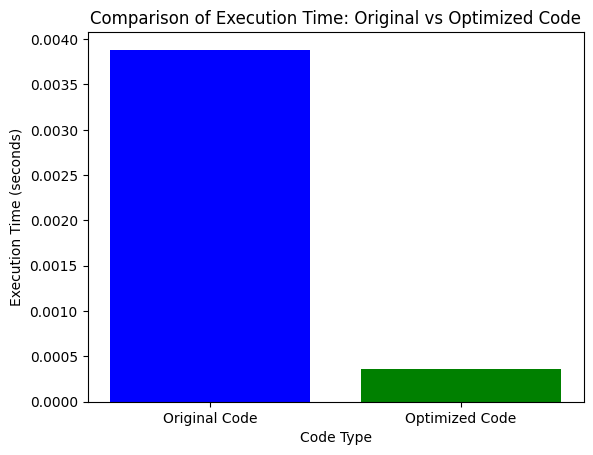

In [17]:
import matplotlib.pyplot as plt

# Data for original and optimized code execution times
original_time = 0.0038836002349853516
optimized_time = 0.0003631114959716797

# Labels for the graph
labels = ['Original Code', 'Optimized Code']
times = [original_time, optimized_time]

# Create a bar graph
plt.bar(labels, times, color=['blue', 'green'])

# Set graph labels and title
plt.xlabel('Code Type')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Execution Time: Original vs Optimized Code')

# Display the graph
plt.show()
